<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # For CPU inference

In [2]:
# Import all necessary libraries.
import numpy as np
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import copy

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [3]:
from NomeroffNet.YoloV5Detector import Detector

detector = Detector()
detector.load()

Fusing layers... 


In [4]:
from BBoxNpMultiline import MultilineConverter
from NomeroffNet.BBoxNpPoints import (NpPointsCraft, 
                                      getCvZoneRGB, 
                                      remove_coordinates_offset,
                                      convertCvZonesRGBtoBGR, 
                                      reshapePoints)

npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights of refiner from checkpoint (/var/www/nomeroff-net22/NomeroffNet/Base/mcm/./models/NpPointsCraft/refiner/craft_refiner_CTW1500_2020-02-16.pth )


In [5]:
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "latest"
    }
})

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

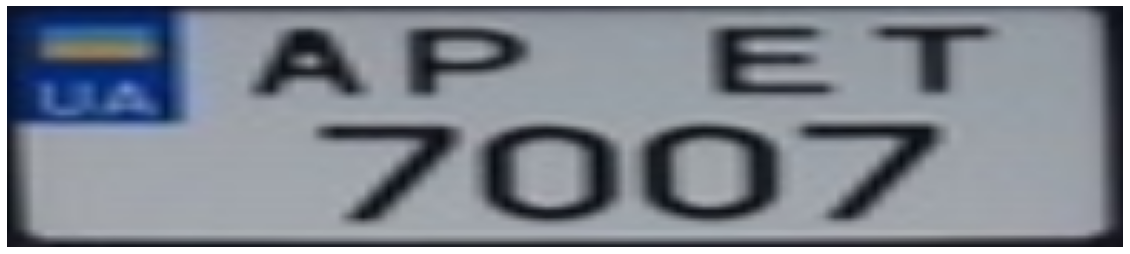

/var/www/nomeroff-net22/NomeroffNet/Base/nnmodels.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = F.softmax(self.fc3_reg(x1))
/var/www/nomeroff-net22/NomeroffNet/Base/nnmodels.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x2 = F.softmax(self.fc3_line(x2))


idx: 1
lines
{1: [{'idx': 0, 'h': 32.0, 'y': 2.6666667}, {'idx': 1, 'h': 32.0, 'y': 2.6666667}], 2: [{'idx': 2, 'h': 27.999998092651367, 'y': 5.3333335}]}
idx: 2
lines
{1: [{'idx': 1, 'h': 32.0, 'y': 2.6666667}, {'idx': 0, 'h': 32.0, 'y': 2.6666667}], 2: [{'idx': 2, 'h': 27.999998092651367, 'y': 5.3333335}]}
(84, 390, 3)
(50, 585, 1)


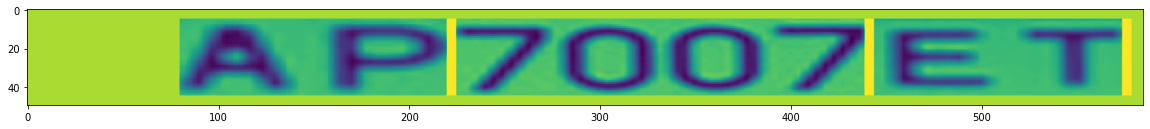

['eu_ua_2015']
[2]
['AP7007ET']


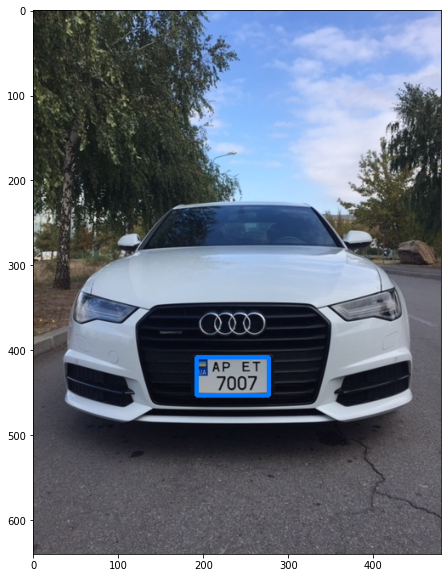

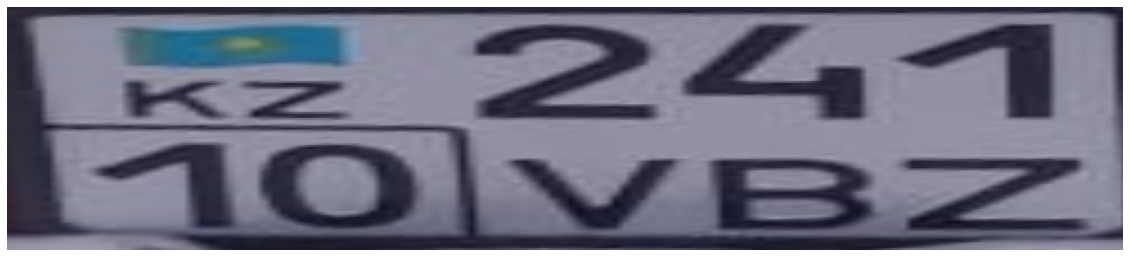

(125, 575, 3)
(72, 1083, 1)


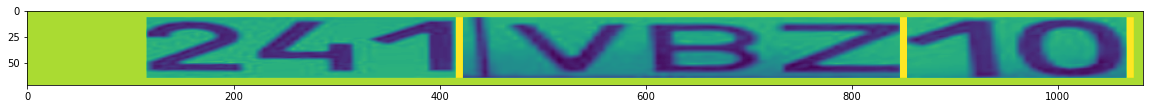

['kz']
[2]
['241VBZ10']


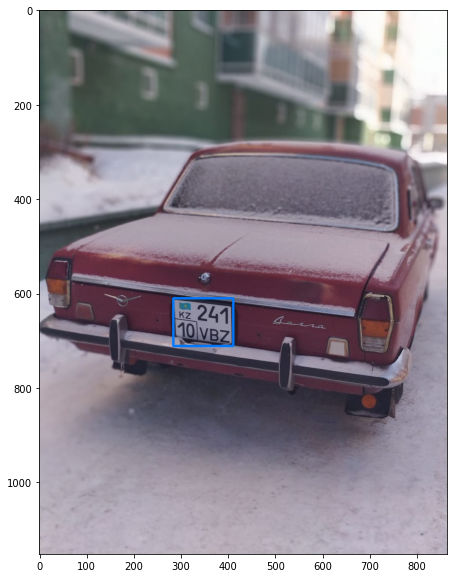

In [7]:
rootDir = 'multiple_number_plate_images/*'

imgs = [mpimg.imread(img_path) for img_path in glob.glob(rootDir)]

for img in imgs:
    targetBoxes = detector.detect_bbox(copy.deepcopy(img))
    targetBoxes = targetBoxes

    all_points, all_properties = npPointsCraft.detect(img, targetBoxes, return_properties=True)
    all_points = [ps for ps in all_points if len(ps)]
#     print('all_points')
#     print(all_points)
#     print('all_properties')
#     print(all_properties)
    

     # cut zones
    toShowZones = [getCvZoneRGB(img, reshapePoints(rect, 1)) for rect in all_points]
    zones = convertCvZonesRGBtoBGR(toShowZones)
    for zone, points in zip(toShowZones, all_points):
        plt.axis("off")
        plt.imshow(zone)
        plt.show()

    # find standart
    regionIds, countLines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    
    for i, (bbox, points, properties, regions) in enumerate(zip(targetBoxes, all_points, all_properties, regionNames)):
        x = int(min(bbox[0], bbox[2]))
        w = int(abs(bbox[2] - bbox[0]))
        y = int(min(bbox[1], bbox[3]))
        h = int(abs(bbox[3] - bbox[1]))
        
        boxPoints = remove_coordinates_offset(points, x, y)
        image_part = img[y:y + h, x:x + w]
        isMultiline = False
        if properties['proportion'] > 0:
            rects = npPointsCraft.detectProbablyMultilineZones(properties['parts'][properties['idx']])
            if len(rects) > 1:
                mc = MultilineConverter(properties['parts'][properties['idx']], rects)
                isMultiline = mc.is_multiline()
                converted_part = mc.covert_to_1_line(regions)
                
                print(zones[i].shape)
                zones[i] = np.reshape(converted_part, [*converted_part.shape, 1])
                print(zones[i].shape)
                
                plt.imshow(converted_part)
                plt.show()
        
    print(regionNames)
    print(countLines)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, countLines)
    print(textArr)
    
    # draw rect and 4 points
    for targetBox, points in zip(targetBoxes, all_points):
        cv2.rectangle(img, 
                      (int(targetBox[0]), int(targetBox[1])), 
                      (int(targetBox[2]), int(targetBox[3])), 
                      (0,120,255), 
                      3)
    plt.imshow(img)
    plt.show()